In [1]:
import matplotlib.pyplot as plt
from scipy.sparse import diags,csr_matrix
from scipy.integrate import simpson
from scipy.sparse.linalg import spsolve,eigsh
import numpy as np
import sympy as sp

In [2]:
def fd_weights ( offsets , order , show_system = False ) :

    """
    Name          : fd_weights -> finite difference weights
    Purpose       : calculate the set of coefficients for a finite difference
                    approximation of the order-th derivative using the given
                    offsets. We are essentually solving the linear system
                    A c = b, where A is the Vandermonde matrix of the offsets,
                    c is the vector of coefficients we want to find, and b is
                    a vector of zeros with a factorial(order) in the order-th
                    position.
    Author          : christlieb, augmented by Joshua Belieu.
    Date augmented  : 2025-08-26
    Last modified   : 2025-08-26
    Inputs :
        - offsets     : list. list of offsets (in units of grid stride h)
        - order       : int. order of derivative to approximate
        - show_system : bool. if True, print the system of equations being
                        solved. default is False.
    Outputs:
        - <ret>: <type> ... <meaning/units/shape>
    Dependencies:
        - None.
    """

    '''
    list of offsets (in units of grid stride h), nsimplify allows floats.
    '''

    s = [ sp.nsimplify ( offset ) for offset in offsets ]
    m = len ( s )

    '''
    the Vandermonde matrix of the offsets. the "A" in our system Ac = b
    '''

    A = sp.Matrix ([[ s[j] ** k for j in range ( m ) ] for k in range ( m )])

    '''
    a vector of zeros with a factorial(order) in the order-th position. the 
    "b" in our system Ac = b.
    '''

    b = sp.Matrix ( [ 0 ] * m )
    b [ order ] = sp.factorial ( order )

    '''
    the coefficients we want to find. the "c" in our system Ac = b. LUsolve is 
    a decomposition method that splits A into a lower and upper triangular matrix
    and solves the system (Ux=y and Ly=c) in two steps.
    '''

    c = A.LUsolve ( b )

    if show_system :

        system = sp.Eq( sp.MatMul ( A , c , evaluate = False ) , b )
        sp.pprint(system)

    return sp.simplify ( c )

h not specified, assuming h = 1.0


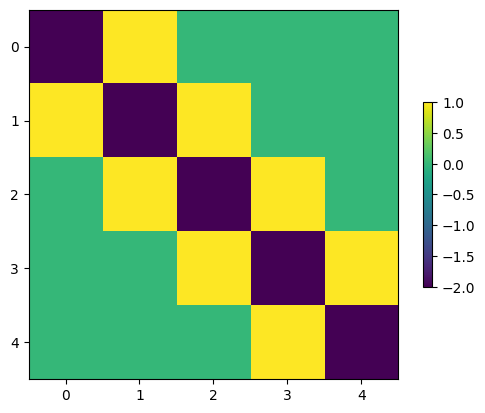

In [3]:
def derivative_1d_stencil ( n = 5 , offsets = [-1,0,1] , order = 2 , h = None ) :

    """
    Name: derivative_1d_stencil
    Purpose: what this subroutine computes and why
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-24
    Last modified: 2025-09-24
    Inputs:
    - arg1: type ... meaning/units/shape
    - arg2: type ... meaning/units/shape
    Outputs:
    - ret: type ... meaning/units/shape
    Dependencies:
    - SubroutineA, SubroutineB, ...
    """

    if h == None :
        print ( "h not specified, assuming h = 1.0" )
        h = 1.0

    weights = [ float(num) for num in np.array(fd_weights ( offsets , order )).flatten()]

    stencil = diags ( weights , offsets , shape = ( n , n ) ) / h**order

    return stencil.toarray()

'''
unit test
'''
test_deriv = derivative_1d_stencil()
plt.imshow(test_deriv)
plt.colorbar(shrink=0.5);

In [4]:
def spectral_radius ( matrix ) :

    """
    Name: spectral_radius
    Purpose: compute the spectral radius of a given matrix
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-09-30
    Inputs:
    - matrix : ndarray/sparse matrix. the matrix to find the spectral radius of.
    Outputs:
    - max_eigenval : float. the absolute value of the largest eigenval
    Dependencies:
    - None.
    """

    eigenvals = np.linalg.eigvals ( matrix )

    max_eigenval = np.max ( np.abs ( eigenvals ) )

    return max_eigenval

In [5]:
def jacobi_iteration ( b , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: jacobi_iteration
    Purpose: use the jacobi iteration method to solve an ODE/PDE
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while error > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * ( u[i+1] + u[i-1] ) - h ** 2 / 2 * b[i]
                error = np.max(np.abs(u_new - u))
                u = u_new
                iteration += 1
    
    if b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while error > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * ( u[i,j+1] + u[i,j-1] + u[i+1,j] + u[i-1,j] ) - h ** 2 / 4 * b[i,j]
            error = np.max(np.abs(u_new - u))
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {error:.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = jacobi_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

In [6]:
def gauss_seidel_iteration ( b , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: gauss_seidel_iteration
    Purpose: Solve Au=b for u via the Gauss-Seidel iterative method.
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-01
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1.
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * ( u[i+1] + u_new[i-1] ) - h ** 2 / 2 * b[i]
                error = u_new - u
                u = u_new
                iteration += 1
    
    elif b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * ( u[i,j+1] + u_new[i,j-1] + u[i+1,j] + u_new[i-1,j] ) - h ** 2 / 4 * b[i,j]
            error = u_new - u
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = gauss_seidel_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

0.1.c

In [7]:
"""
Name: show spectral radius
Purpose: compute the spectral radius of the jacobi and gauss-seidel methods to
         give us an idea of the convergance of the methods.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-01
Inputs:
- n : int. number of mesh points
Outputs:
- spectral radius : float. the spectral radius of jacobi and gauss-seidel iteration
                    matrices
Dependencies:
- diags, spectral_radius, numpy
"""

n = 32
h = 1/(n-1)

e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))

jacobi_iteration_matrix = -np.linalg.inv ( D.toarray() ) @ ( L + U ).toarray()
gauss_seidel_iteration_matrix = -np.linalg.inv ( (D-L).toarray() ) @ ( U ).toarray()

jacobi_spectral_radius = spectral_radius ( jacobi_iteration_matrix )
gauss_seidel_spectral_radius = spectral_radius ( gauss_seidel_iteration_matrix )

print(jacobi_spectral_radius,gauss_seidel_spectral_radius)

0.9954719225730841 0.9909643486313532


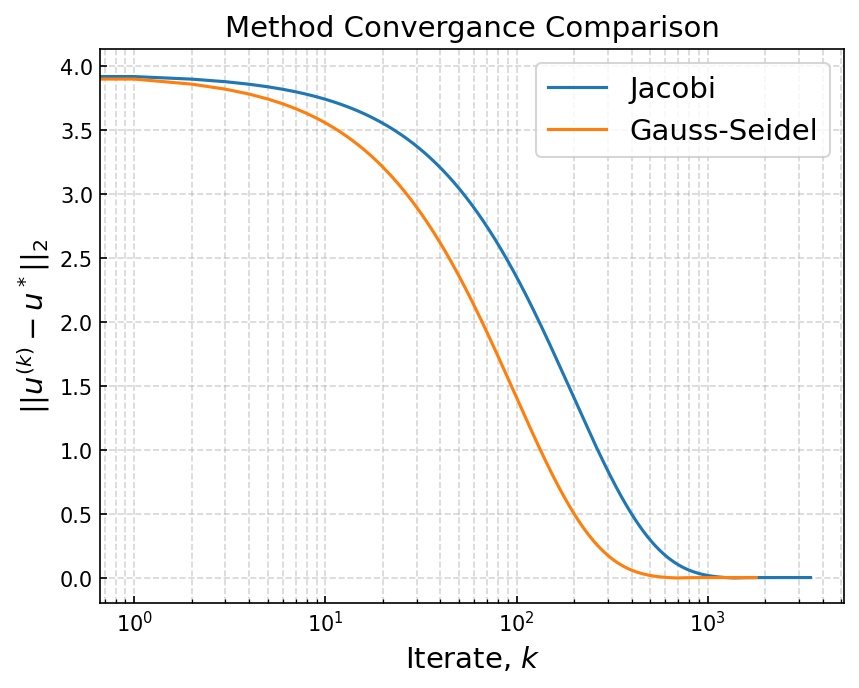

In [8]:
"""
Name: method convergance comparison
Purpose: make a plot showing the convergance of the gauss-seidel and jacobi 
         iteration methods.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-01
Inputs:
- n: int. number of mesh points.
- domain (x): array-like. domain of system.
- f : array-like. RHS of ODE
- tolerance : float. tolerance of iterate convergance.
- max_iteration : int. maximum iterations for method.
Outputs:
- plot : canvas. a plot of the convergances of the gauss-seidel and jacobi 
         methods.
Dependencies:
- jacobi/gauss_seidel_iteration, numpy, matplotlib
"""

n=32
x = np.linspace(0,1,n)
u_star = np.sin( np.pi * x )
f = -np.pi**2*u_star

u_jacobi,u_jacobi_iterates,jacobi_iterates = jacobi_iteration ( f ,tolerance=1e-10, max_iteration=int(1e4) )
u_gauss_seidel,u_gauss_seidel_iterates,gauss_seidel_iterates = gauss_seidel_iteration ( f , tolerance=1e-10,max_iteration=int(1e4) )

jacobi_l2norm = []
for u_iterate in u_jacobi_iterates :
    l2norm = np.linalg.norm ( np.abs(u_iterate - u_star) )
    jacobi_l2norm.append(l2norm)
gs_l2norm = []
for u_iterate in u_gauss_seidel_iterates :
    l2norm = np.linalg.norm ( np.abs(u_iterate - u_star) )
    gs_l2norm.append(l2norm)
plt.figure(dpi=150)
plt.plot(jacobi_iterates,jacobi_l2norm,label='Jacobi')
plt.plot(gauss_seidel_iterates,gs_l2norm,label=r'Gauss-Seidel')
plt.title('Method Convergance Comparison',fontsize=14)
# plt.yscale('log')
plt.xlabel(r'Iterate, $k$',fontsize=14)
plt.ylabel(r'$||u^{(k)}-u^*||_2$',fontsize=14)
plt.xscale('log')
plt.tick_params(direction='in',which='both')
plt.grid(which='both',ls='--',alpha=0.5)
plt.legend(fontsize=14);

0.2.b

In [9]:
def sor_iteration ( b , w = 1. , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: sor_iteration
    Purpose: Solve Au=b for u via the succesive over relaxation (SOR) iterative
             method.
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-01
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - w : float. the mixing parameter that controls the update of the u 
          iterate.
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1.
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * w * ( u[i+1] + u_new[i-1] - h ** 2 * b[i] ) + (1-w)*u[i]
                error = u_new - u
                u = u_new
                iteration += 1
    
    elif b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * w * ( u[i+1,j] + u_new[i-1,j] + u[i,j+1] + u_new[i,j-1] - h ** 2 * b[i,j] ) + (1-w)*u[i,j]
            error = u_new - u
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = gauss_seidel_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

w : 0.5 | slope : 9.925e-01 | intercept : 3.753e+01
w : 0.8 | slope : 9.888e-01 | intercept : 2.816e+01
w : 1.0 | slope : 9.857e-01 | intercept : 2.376e+01
w : 1.2 | slope : 9.816e-01 | intercept : 2.018e+01
w : 1.5 | slope : 9.708e-01 | intercept : 1.597e+01
w : 1.8 | slope : 9.210e-01 | intercept : 1.645e+01


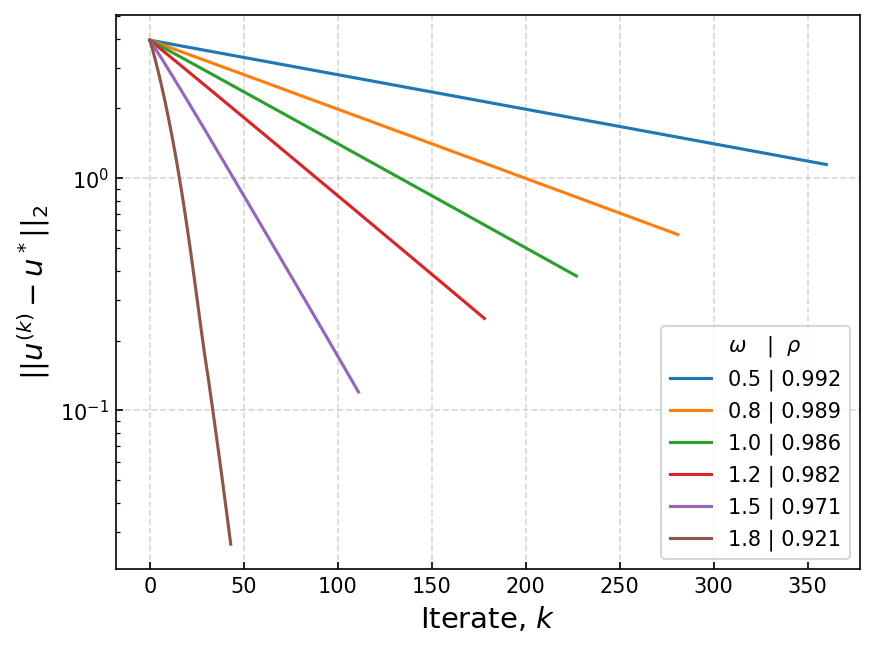

In [10]:
"""
Name: asymptotic rate fitter
Purpose: make a plot showing the convergance of the SOR method and fit a line
         to get some notion of the spectral radius of the iteration matrix.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-02
Inputs:
- n: int. number of mesh points.
- domain (x): array-like. domain of system.
- f : array-like. RHS of ODE
- tolerance : float. tolerance of iterate convergance.
- max_iteration : int. maximum iterations for method.
- w_list : list. collection of mixing parameters for w.
Outputs:
- plot : canvas. a plot of the convergances of the gauss-seidel and jacobi 
         methods.
Dependencies:
- jacobi/gauss_seidel_iteration, numpy, matplotlib
"""

n=32
x = np.linspace(0,1,n)
u_star = np.sin( np.pi * x )
f = -np.pi**2*u_star
w_list = [0.5,0.8,1.0,1.2,1.5,1.8]

sor_l2norm = []
sor_iterates_list = []
slope_list = []
plt.figure(dpi=150)
for w in w_list : 

    u_sor,u_sor_iterates,sor_iterates = sor_iteration ( f ,w=w ,tolerance=1e-3, max_iteration=int(1e6) )
    l2norms = [ np.linalg.norm( np.abs(u_iterate - u_star) ) for u_iterate in u_sor_iterates ]
    sor_l2norm.append(l2norm)
    sor_iterates_list.append(sor_iterates)
    slope , intercept = np.polyfit ( sor_iterates , l2norms , 1 )
    slope_list.append(np.exp(slope))
    print(f"w : {w} | slope : {np.exp(slope):.3e} | intercept : {np.exp(intercept):.3e}")
    plt.plot(sor_iterates,l2norms,label=f"{w} | {np.exp(slope):.3f}")

plt.yscale('log')
plt.legend(title=r'   $\omega$   |  $\rho$')
plt.xlabel(r'Iterate, $k$',fontsize=14)
plt.ylabel(r'$||u^{(k)}-u^*||_2$',fontsize=14)
plt.tick_params(direction='in',which='both')
plt.grid(which='major',ls='--',alpha=0.5);

0.2.c

w : 0.5 | Spec. Rad. : 9.970e-01 | Slope : 9.925e-01 | SR-Slope : 4.520e-03
w : 0.8 | Spec. Rad. : 9.940e-01 | Slope : 9.888e-01 | SR-Slope : 5.220e-03
w : 1.0 | Spec. Rad. : 9.910e-01 | Slope : 9.857e-01 | SR-Slope : 5.314e-03
w : 1.2 | Spec. Rad. : 9.864e-01 | Slope : 9.816e-01 | SR-Slope : 4.879e-03
w : 1.5 | Spec. Rad. : 9.726e-01 | Slope : 9.708e-01 | SR-Slope : 1.841e-03
w : 1.8 | Spec. Rad. : 8.981e-01 | Slope : 9.210e-01 | SR-Slope : -2.290e-02


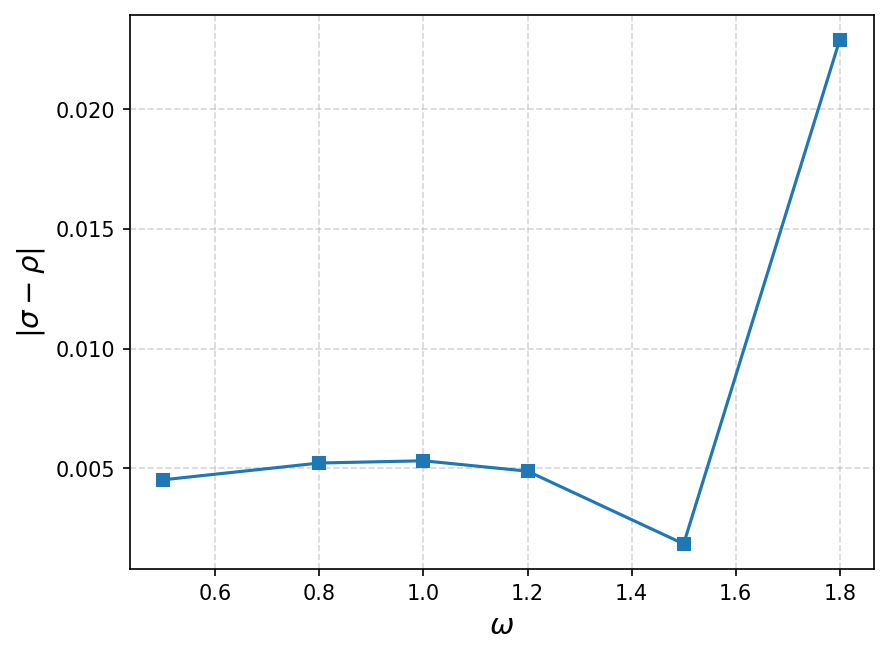

In [11]:
"""
Name: comparing numerical vs theoretical rate
Purpose: compute the spectral radius of the sor iteration matrix and compare its
         value to the slope of the error from the previous problem.
Author: Joshua Belieu | Fletch
Date written: 2025-10-02
Last modified: 2025-10-02
Inputs:
- n : int. number of mesh points
- h : float. mesh stride.
- w_list : list. list of w parameters for SOR
Outputs:
- table : table. table of values containing w, spectral radius, slope, and their
          difference.
- plot : canvas. the plot of w vs |spec. rad. - slope|
Dependencies:
- numpy, diags, spectral_radius, matplotlib
"""

n = 32
h = 1/(n-1)

e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))

sor_spec_rad_list = []
for i,w in enumerate(w_list) :
    sor_iteration_matrix = -np.linalg.inv ( D.toarray()+w*L.toarray() ) @ ( (1-w)*D.toarray() - w*U.toarray() )
    sor_spectral_radius = spectral_radius(sor_iteration_matrix)
    sor_spec_rad_list.append(sor_spectral_radius)
    print(f"w : {w} | Spec. Rad. : {sor_spectral_radius:.3e} | Slope : {slope_list[i]:.3e} | SR-Slope : {sor_spectral_radius-slope_list[i]:.3e}")

plt.figure(dpi=150)
plt.plot(w_list,np.abs(np.array(sor_spec_rad_list)-np.array(slope_list)),marker='s')
plt.xlabel(r'$\omega$',fontsize=14)
plt.ylabel(r'$|\sigma-\rho|$',fontsize=14)
plt.grid(ls='--',alpha=0.5);

0.3.c

In [12]:
def jacobi_iteration_with_iteration_matrix ( T , c , u0 = None , 
                                            tolerance = 1e-5 , 
                                            max_iterations = 1000 , 
                                            show_final_stats = False ) :

    n = T.shape[0]
    if u0 is None :
        u = np.zeros( n )
    else :
        u = u0.copy()

    iterations = 0
    error = 1.
    u_iterates = []
    iterations_list = []

    while error > tolerance and iterations < max_iterations :
        u_iterates.append(u)
        iterations_list.append( iterations )

        u_new = T @ u + c
        error = np.max ( np.abs ( u - u_new ) )
        u = u_new

        iterations += 1

    if show_final_stats == True :
        
        out_str = f'Final Stats : \n Iteration : {iterations} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print ( out_str )

    return u , u_iterates , iterations_list

def gaussseidel_iteration_with_iteration_matrix ( T , c , u0 = None , 
                                            tolerance = 1e-5 , 
                                            max_iterations = 1000 , 
                                            show_final_stats = False ) :

    n = T.shape[0]
    if u0 is None :
        u = np.zeros( n )
    else :
        u = u0.copy()

    iterations = 0
    error = 1.
    u_iterates = []
    iterations_list = []

    while error > tolerance and iterations < max_iterations :
        u_iterates.append(u)
        iterations_list.append( iterations )

        # u_old = u.copy()

        u_new = T @ u + c

        # for i in range ( n ) : 
        #     u[i] = T[i,:i] @ u[:i] + T[i,i:] @ u_old[i:] + c[i]
            
        error = np.max ( np.abs ( u - u_new ) )
        iterations += 1
        u = u_new

    if show_final_stats == True :
        
        out_str = f'Final Stats : \n Iteration : {iterations} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print ( out_str )

    return u , u_iterates , iterations_list

/tmp/ipykernel_2682/3944087409.py:22: RuntimeWarning: overflow encountered in subtract
  error = np.max ( np.abs ( u - u_new ) )
/tmp/ipykernel_2682/3944087409.py:21: RuntimeWarning: overflow encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_2682/3944087409.py:21: RuntimeWarning: invalid value encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_2682/3944087409.py:56: RuntimeWarning: overflow encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_2682/3944087409.py:56: RuntimeWarning: invalid value encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_2682/3944087409.py:61: RuntimeWarning: invalid value encountered in subtract
  error = np.max ( np.abs ( u - u_new ) )
/home/jabelieu/Desktop/nmfde_class/.venv_nmfde/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)


Method : Jacobi | slope : 2.828e+00 | intercept : 2.414e-01
Method : Gauss-Seidel | slope : 2.718e+00 | intercept : 1.000e+00


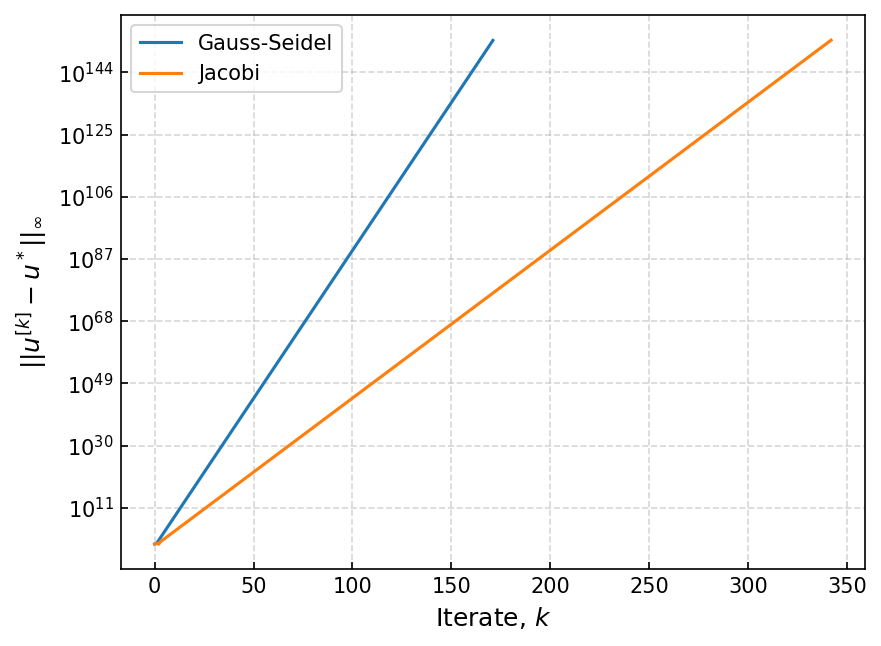

In [ ]:
n=3
#ChatGPT generated this tj, i asked what the corresponding A is and it generated:
A=np.array([[-2,-4,0],[-4,-2,-4],[0,-4,-2]])
f = np.array([1]*n)
D = np.diag(np.diag(A))
L = np.tril(A, -1)
U = np.triu(A, 1)

tj  = -np.linalg.inv(D) @ (L + U)
cj  = np.linalg.inv(D) @ f
tgs = -np.linalg.inv(D + L) @ U
cgs = np.linalg.inv(D + L) @ f

x = np.linspace(0,1,n)
u_star = np.sin( np.pi * x )
u_true = np.linalg.solve(A,f)
error_list = []
gs_error_list = []

utj_sol , utj_iterates , tj_iterations_list = jacobi_iteration_with_iteration_matrix ( tj , cj )
utgs_sol , utgs_iterates , tgs_iterations_list = gaussseidel_iteration_with_iteration_matrix ( tgs , cgs )
for i in range ( len(utj_iterates) ) :

    u_approx_i = utj_iterates[i]
    error = np.linalg.norm(np.abs(u_approx_i-u_star))
    error_list.append(error)

for i in range ( len(utgs_iterates) ) :

    u_approx_i = utgs_iterates[i]
    error = np.linalg.norm(np.abs(u_approx_i-u_star))
    gs_error_list.append(error)

j_finite_idxs = np.where(np.isfinite(error_list))[0]
gs_finite_idxs = np.where(np.isfinite(error_list))[0]


jslope , jintercept = np.polyfit ( np.array(tj_iterations_list)[j_finite_idxs],
                                  np.log(np.array(error_list)[j_finite_idxs]), 1 )
gsslope , gsintercept = np.polyfit ( np.array(tgs_iterations_list)[gs_finite_idxs],
                                    np.array(tgs_iterations_list)[gs_finite_idxs] , 1 )


print(f"Method : Jacobi | slope : {np.exp(jslope):.3e} | intercept : {np.exp(jintercept):.3e}")
print(f"Method : Gauss-Seidel | slope : {np.exp(gsslope):.3e} | intercept : {np.exp(gsintercept):.3e}")

plt.figure(dpi=150)
plt.plot(tgs_iterations_list,gs_error_list,label='Gauss-Seidel')
plt.plot(tj_iterations_list,error_list,label='Jacobi')
plt.xlabel(r'Iterate, $k$',fontsize=12)
plt.ylabel(r'$||u^{[k]}-u^*||_\infty$',fontsize=12)
plt.yscale('log')
plt.tick_params(direction='in',which='both')
plt.grid(ls='--',alpha=0.5)
plt.legend(fontsize=10);

0.4.b

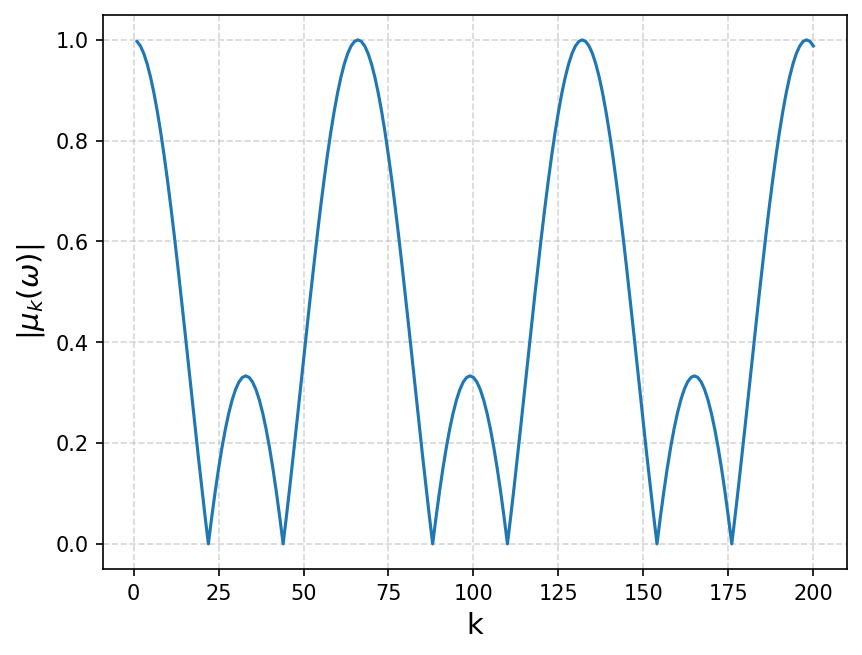

In [42]:
n = 32
w = 2/3
theta_k = lambda k : k * np.pi / ( n + 1 )
mu_k = lambda k : 1-w + w * np.cos ( theta_k(k) )

k_list = np.arange( 1 , 200 + 1 )
mag_mu_k = np.abs ( mu_k ( k_list ) )

plt.figure(dpi=150)
plt.plot(k_list, mag_mu_k)
plt.xlabel('k',fontsize=14)
plt.ylabel(r'$|\mu_k(\omega)|$',fontsize=14)
plt.grid(ls='--',alpha=0.5);

0.4.c

''

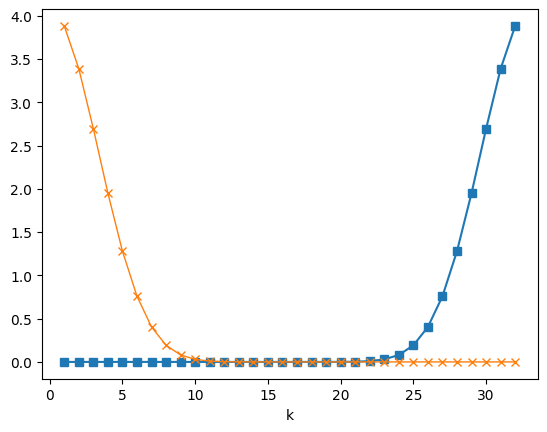

In [94]:
n = 32
w = 2/3
max_steps = 15 
theta_k = lambda k : k * np.pi / ( n + 1 )
mu_k = lambda k : 1-w + w * np.cos ( theta_k(k) )
i_arr = np.arange ( 1 , n + 1 )
error_measured = []
error_theory = []
Gw = (1-w)*np.eye(n) - 0.5 * w * diags ( [np.ones(n-1)]*2 , offsets = [1,-1] ).toarray() # leveque
# Gw = np.eye(n) - w * (diags([ -1*np.ones(n-1), 2*np.ones(n), -1*np.ones(n-1) ], offsets=[-1,0,1]).toarray() / 2) # gpt

for k in range ( 1 , n + 1 ) :

    theta_k_val = theta_k ( k )
    phi_k = np.sin( theta_k_val * i_arr )
    phi_c = phi_k.copy()
    mu_k_val = mu_k ( k )

    for step in range(max_steps):
        phi_c = Gw @ phi_c  # For sine modes, exact update is mu_k * phi

    phi_k *= mu_k(k) ** max_steps
    error_measured.append(np.linalg.norm(phi_c))
    error_theory.append(np.linalg.norm(phi_k))

error_measured = np.array(error_measured)
error_theory = np.array(error_theory)

plt.plot(i_arr, error_measured, marker='s', label='Measured error')
plt.plot(i_arr, error_theory, marker='x',lw=1, label='Theoretical error')
# plt.plot(i_arr,error_theory-error_measured)
plt.xlabel('k')
# plt.legend()
;

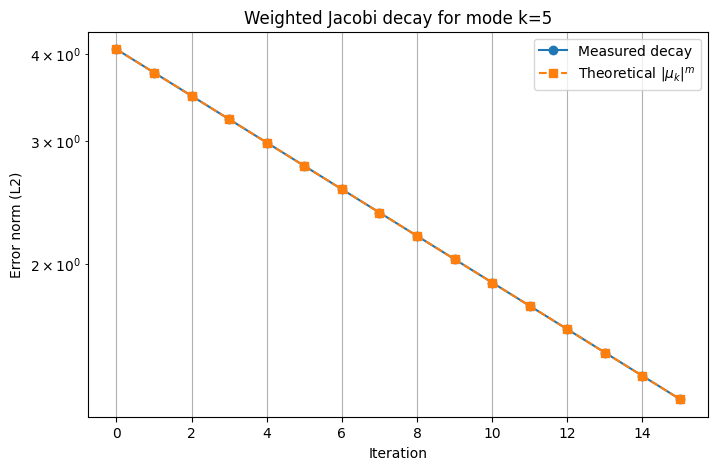

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 32           # number of interior points
omega = 2/3      # weighted Jacobi weight
steps = 15       # number of iterations

# Grid and Poisson matrix setup
h = 1.0 / (n + 1)
x = np.linspace(h, 1-h, n)

# Weighted Jacobi iteration matrix A = 1D Poisson
# A is tridiagonal with 2 on diagonal and -1 on off-diagonal
A = (2*np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1)) / h**2

# Compute D^{-1} (Jacobi) and iteration matrix
D_inv = np.diag(1 / np.diag(A))
M = np.eye(n) - omega * D_inv @ A  # Weighted Jacobi iteration matrix

# Function to generate sine mode
def phi(k):
    return np.sin(k * np.pi * x)

# Choose a mode k
k = 5
error = phi(k)       # initialize error as phi_k
mu_k = 1 - omega * (1 - np.cos(k * np.pi * h))  # amplification factor formula

# Store error norms
error_norms = [np.linalg.norm(error)]

# Weighted Jacobi iterations
for _ in range(steps):
    error = M @ error
    error_norms.append(np.linalg.norm(error))

# Compute theoretical decay
theory_decay = [np.linalg.norm(phi(k)) * abs(mu_k)**m for m in range(steps+1)]

# Plot
plt.figure(figsize=(8,5))
plt.semilogy(range(steps+1), error_norms, 'o-', label='Measured decay')
plt.semilogy(range(steps+1), theory_decay, 's--', label=r'Theoretical $|\mu_k|^m$')
plt.xlabel('Iteration')
plt.ylabel('Error norm (L2)')
plt.title(f'Weighted Jacobi decay for mode k={k}')
plt.legend()
plt.grid(True)
plt.show()


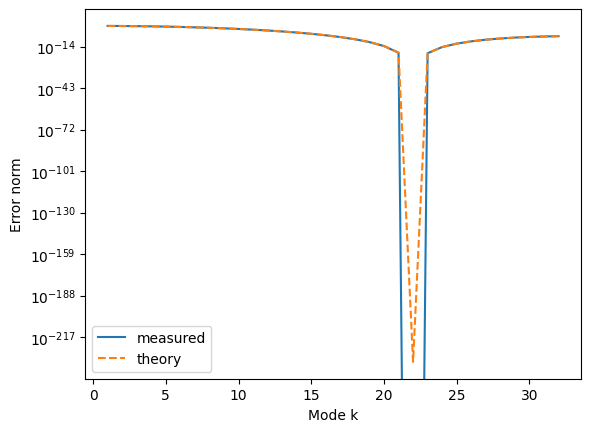

In [51]:
n = 32
w = 2/3
max_steps = 15

theta_k = lambda k: k * np.pi / (n + 1)
mu_k = lambda k: 1 - w + w * np.cos(theta_k(k))
i_arr = np.arange(1, n + 1)
error_measured = []
error_theory = []

for k in range(1, n + 1):
    phi = np.sin(theta_k(k) * i_arr)  # initial error mode
    
    # Apply weighted Jacobi m times
    for step in range(max_steps):
        phi = mu_k(k) * phi  # For sine modes, exact update is mu_k * phi
    
    error_measured.append(np.linalg.norm(phi))
    error_theory.append(np.linalg.norm(np.sin(theta_k(k) * i_arr)) * abs(mu_k(k))**max_steps)

plt.plot(range(1, n+1), error_measured, label='measured')
plt.plot(range(1, n+1), error_theory, '--', label='theory')
plt.xlabel('Mode k')
plt.ylabel('Error norm')
plt.yscale('log')
plt.legend()
plt.show()


1.5.b

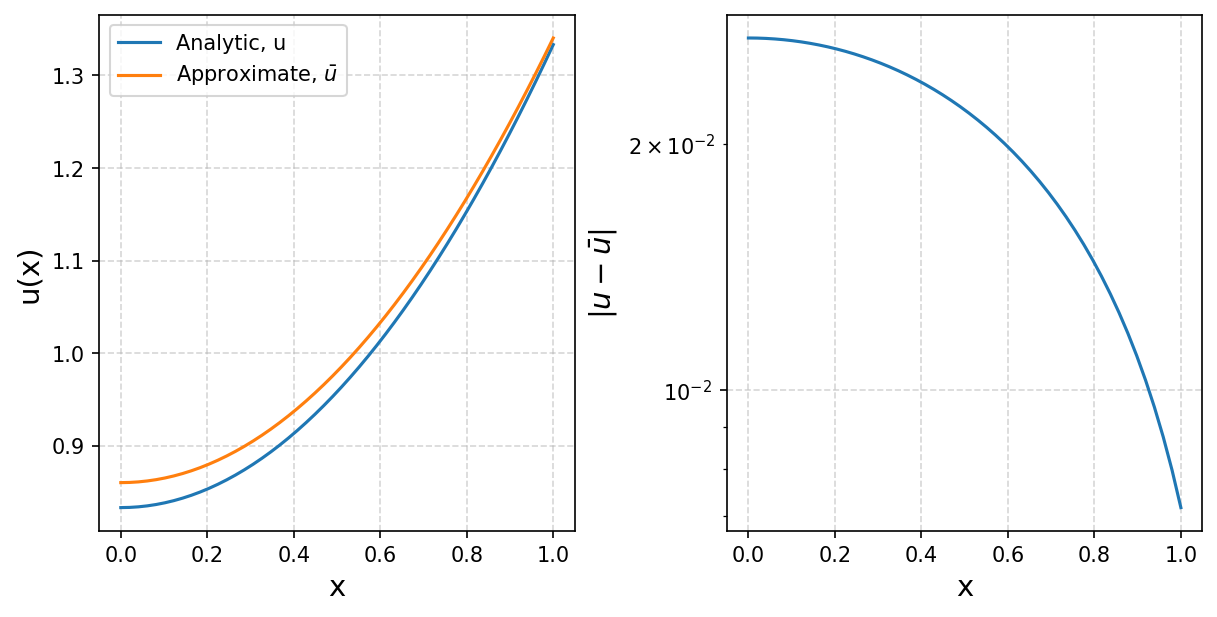

In [14]:
"""
Name: method convergance plot
Purpose: make a plot showing the convergance performance of system ODE.
Author: Joshua Belieu | Fletch
Date written: 2025-09-24
Last modified: 2025-10-01
Inputs:
- x_low/high : float. system domain bounds.
- n : int. number of mesh points
- neumann bcs : array-like. stencil of coefficients for neumann boundary 
                condtion.
- f : array-like. RHS of ODE AND neumann BC/normalization conditon.
Outputs:
- plot : canvas. a plot of the true analytic and approximate solution along with
         the absolute value of their residual.
Dependencies:
- derivative_1d_stencil, fd_weights, csr_matrix, numpy, matplotlib
"""

x_low = 0.
x_high = 1.
n = int(5e1)
h = x_high / ( n )

offsets = [ -1 , 0 , 1 ]
derivative_matrix = derivative_1d_stencil(n,h=h)
stencil_nobc = derivative_matrix.copy()
left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2],1 )).flatten()])

derivative_matrix[0,0:3] = left_neumann / h

f = np.ones ( n-1 )
f[0]=0.

norm_cond = np.ones ( n ) * h
norm_cond[0]=h/2;norm_cond[-1]=h/2
derivative_matrix[-1,:] = norm_cond
f = np.append(f,1.0)

u = spsolve ( csr_matrix(derivative_matrix) , f )

x = np.linspace ( x_low , x_high , n )
true = 0.5*x**2+5/6

fig,axs = plt.subplots(1,2,figsize=(8,4),constrained_layout=True,dpi=150)
axs[0].plot( x , true ,label='Analytic, u')
axs[0].plot( x , u , label = r'Approximate, $\bar{u}$')
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('u(x)', fontsize=14)
axs[0].grid(ls='--',alpha=0.5)
axs[1].plot( x , np.abs(u - true))
axs[1].set_xlabel('x', fontsize=14)
axs[1].set_ylabel(r'$|u-\bar{u}|$', fontsize=14)
axs[1].set_yscale('log')
axs[1].grid(ls='--',alpha=0.5)
axs[0].legend();

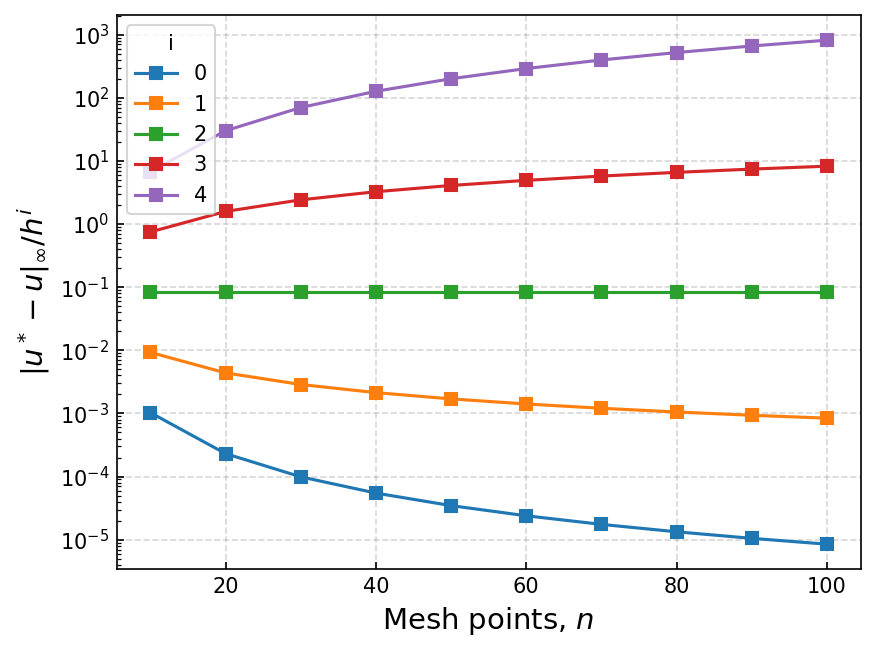

In [15]:
"""
Name: order tester
Purpose: test the order of a method at different step sizes.
Author: Joshua Belieu | Fletch
Date written: 2025-09-24
Last modified: 2025-10-01
Inputs:
- x_low/high : floats. system domain limits.
- n_list : array-like. array of ints giving mesh grid size.
- offsets : list. offsets of stencil
- ODE conditions : multi. neumann boundary condition and normalization 
                   condition.
- f : array-like. blend of ODE RHS and condition values.
Outputs:
- plot : n_list vs error/(h^i). this shows what the order of the method is.
         curves with slope ~ 0 are the order.
Dependencies:
- fd_weights, derivatie_1d_stencil, numpy, matplotlib
"""

x_low = 0.
x_high = 1.
n_list = range(10,110,10)

offsets = [ -1 , 0 , 1 ]
h_list = []
max_error_list = []

for n in n_list : 

    h = x_high / ( n-1 )

    derivative_matrix = derivative_1d_stencil(n,h=h)

    left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2,3],1 )).flatten()])

    derivative_matrix[0,0:len(left_neumann)] = left_neumann / h

    f = np.ones ( n-1 )
    f[0]=0.

    norm_cond = np.ones ( n ) * h
    norm_cond[0]=h/2;norm_cond[-1]=h/2
    derivative_matrix[-1,:] = norm_cond
    f = np.append(f,1.0)

    u = spsolve ( csr_matrix(derivative_matrix) , f )    
    x = np.linspace ( x_low , x_high , n )
    true = 0.5*x**2+5/6

    h_list.append(h)
    max_error_list.append ( np.max ( np.abs ( u - true )))
plt.figure(dpi=150)
for order in range ( 0 , 4 + 1 ) :
    plt.plot ( n_list , np.array(max_error_list)/np.array(h_list)**order ,label=order,marker='s')
plt.yscale('log')
plt.grid(ls='--',alpha=0.5,which='major')
plt.xlabel( r'Mesh points, $n$',fontsize=14 )
plt.ylabel (r'$|u^*-u|_\infty/h^i$',fontsize=14)
plt.tick_params(direction='in',which='both')
plt.legend(title='i');